In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 1. Load Test Data
test_data = pd.read_csv("annotated_participant_gesture_dataset.csv")


In [7]:
# Define Model Architecture
class ArmGestureNet(nn.Module):
    def __init__(self, input_size=18, num_classes=3):
        super(ArmGestureNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.4)
        self.batchnorm = nn.BatchNorm1d(128)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# 2. Preprocessing Function
def process_landmarks(landmark_str):
    # Convert string representation to numpy array
    landmarks = np.array(eval(landmark_str))

    # Select relevant landmarks (indices 11-16: shoulders, elbows, wrists)
    selected_indices = [11, 12, 13, 14, 15, 16]
    selected_landmarks = landmarks[selected_indices]

    # Flatten to 18-dimensional vector (6 landmarks × 3 coordinates)
    return selected_landmarks.flatten()



In [9]:
# 3. Prepare Data
X_test = np.array([process_landmarks(x) for x in test_data["landmarks"]])
y_test = test_data["true gesture"].map({"left": 0, "right": 1, "stop": 2}).values

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)


In [10]:

# 4. Load Model
model = ArmGestureNet(input_size=18)
model.load_state_dict(torch.load("/content/drive/My Drive/Cmpt_419_Project/arm_gesture_landmark_model.pth", map_location=torch.device("cpu")))
model.eval()



ArmGestureNet(
  (fc1): Linear(in_features=18, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
# 5. Make Predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    confidences, predictions = torch.max(probabilities, 1)



In [12]:
# 6. Apply Confidence Threshold (0.9)
confident_mask = confidences >= 0.9
filtered_preds = predictions[confident_mask]
filtered_true = y_test_tensor[confident_mask]



In [13]:
# 7. Calculate Metrics
accuracy = accuracy_score(filtered_true, filtered_preds)
cm = confusion_matrix(filtered_true, filtered_preds)

print(f"Accuracy (confident predictions): {accuracy:.2%}")
print("Confusion Matrix:")
print(cm)



Accuracy (confident predictions): 90.13%
Confusion Matrix:
[[55  0  7]
 [ 0 57  8]
 [ 0  0 25]]


In [14]:
# 8. Full Analysis
all_preds = predictions.numpy()
print("\nFull dataset analysis:")
print(f"Total samples: {len(y_test)}")
print(f"Confident predictions: {confident_mask.sum().item()}/{len(y_test)}")
print(f"Overall accuracy: {accuracy_score(y_test, all_preds):.2%}")
print(f"Uncertain samples: {len(y_test) - confident_mask.sum().item()}")


Full dataset analysis:
Total samples: 152
Confident predictions: 152/152
Overall accuracy: 90.13%
Uncertain samples: 0


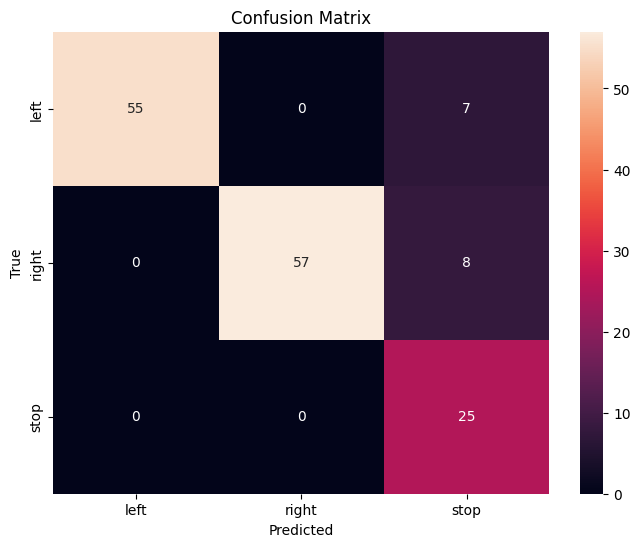

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["left", "right", "stop"],
            yticklabels=["left", "right", "stop"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()